### This notebook contains data preprocessing code to convert the DETRAC train annotations to fit the format required by the PersonReID model
### https://github.com/layumi/Person_reID_baseline_pytorch

### DETRAC dataset : http://detrac-db.rit.albany.edu/

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
import time
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
from tqdm import tqdm

### Get all annotation file paths

In [35]:
train_anno = 'DETRAC-Train-Annotations-XML-v3'
anno_xmls = []
folder_name = []
xml_list = os.listdir(train_anno)
for anno_xml in xml_list:
    anno_xmls.append(os.path.join(train_anno, anno_xml))
    folder_name.append(anno_xml[:-7])
print('\n'.join(anno_xmls[:5]))
print(len(anno_xmls))

DETRAC-Train-Annotations-XML-v3\MVI_20011_v3.xml
DETRAC-Train-Annotations-XML-v3\MVI_20012_v3.xml
DETRAC-Train-Annotations-XML-v3\MVI_20032_v3.xml
DETRAC-Train-Annotations-XML-v3\MVI_20033_v3.xml
DETRAC-Train-Annotations-XML-v3\MVI_20034_v3.xml
60


In [36]:
print('\n'.join(folder_name[:5]))
print(len(folder_name))

MVI_20011
MVI_20012
MVI_20032
MVI_20033
MVI_20034
60


### Get all image file paths

In [37]:
train_image = 'Insight-MVT_Annotation_Train'
train_imgs = []
img_folder_name = []
img_list = os.listdir(train_image)
for train_img in img_list:
    train_imgs.append(os.path.join(train_image, train_img))
    img_folder_name.append(train_img)
print('\n'.join(train_imgs[:5]))
print(len(train_imgs))

Insight-MVT_Annotation_Train\MVI_20011
Insight-MVT_Annotation_Train\MVI_20012
Insight-MVT_Annotation_Train\MVI_20032
Insight-MVT_Annotation_Train\MVI_20033
Insight-MVT_Annotation_Train\MVI_20034
60


In [38]:
print(*img_folder_name[:5], sep='\n')
print(len(img_folder_name))

MVI_20011
MVI_20012
MVI_20032
MVI_20033
MVI_20034
60


### Methods here

In [3]:
def mkdir_if_missing(dir):
    os.makedirs(dir, exist_ok=True)

def slice_det(frame, box):
    x1, y1 = box[0], box[1]
    x2, y2 = box[0] + box[2], box[1] + box[3]
    return img[y1:y2, x1:x2]

### Get all bounding boxes via ID

In [44]:
%%time
# This det dict contains all ground truth detection boxes, the key is the video name for slicing the image later on
det_dict = {}

# Loop all anno files
for idx in range(len(anno_xmls)):
    print(f'Processing: {anno_xmls[idx]}')
    root = ET.parse(anno_xmls[idx]).getroot()
    vid_name = folder_name[idx]
    
    # Check if vid name is already present
    if vid_name not in det_dict.keys():
        det_dict[vid_name] = {}
    
    # Loop all xml nodes
    for frame in root:
        if (frame.tag != 'frame'):
            continue
        frame_name = train_imgs[idx] + '\\' + 'img' + frame.attrib['num'].zfill(5) + '.jpg'
        # Loop target nodes
        for target in frame[0]:
            id = target.attrib['id']

            # Check if target id is already created
            if id not in det_dict[vid_name].keys():
                det_dict[vid_name][id] = []

            # Append an array [Frame file name, BBox.Left, BBox.Top, BBox.Width, BBox.Height]
            det_dict[vid_name][id].append([
                frame_name,
                float(target[0].attrib['left']),
                float(target[0].attrib['top']),
                float(target[0].attrib['width']),
                float(target[0].attrib['height'])
            ])

Processing: DETRAC-Train-Annotations-XML-v3\MVI_20011_v3.xml
Processing: DETRAC-Train-Annotations-XML-v3\MVI_20012_v3.xml
Processing: DETRAC-Train-Annotations-XML-v3\MVI_20032_v3.xml
Processing: DETRAC-Train-Annotations-XML-v3\MVI_20033_v3.xml
Processing: DETRAC-Train-Annotations-XML-v3\MVI_20034_v3.xml
Processing: DETRAC-Train-Annotations-XML-v3\MVI_20035_v3.xml
Processing: DETRAC-Train-Annotations-XML-v3\MVI_20051_v3.xml
Processing: DETRAC-Train-Annotations-XML-v3\MVI_20052_v3.xml
Processing: DETRAC-Train-Annotations-XML-v3\MVI_20061_v3.xml
Processing: DETRAC-Train-Annotations-XML-v3\MVI_20062_v3.xml
Processing: DETRAC-Train-Annotations-XML-v3\MVI_20063_v3.xml
Processing: DETRAC-Train-Annotations-XML-v3\MVI_20064_v3.xml
Processing: DETRAC-Train-Annotations-XML-v3\MVI_20065_v3.xml
Processing: DETRAC-Train-Annotations-XML-v3\MVI_39761_v3.xml
Processing: DETRAC-Train-Annotations-XML-v3\MVI_39771_v3.xml
Processing: DETRAC-Train-Annotations-XML-v3\MVI_39781_v3.xml
Processing: DETRAC-Train

In [45]:
det_dict['MVI_20011'].keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '11', '9', '10', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45', '47', '48', '49', '46', '50', '51', '52', '53'])

In [46]:
det_dict['MVI_20011']['1']

[['Insight-MVT_Annotation_Train\\MVI_20011\\img00001.jpg',
  592.75,
  378.8,
  160.05,
  162.2],
 ['Insight-MVT_Annotation_Train\\MVI_20011\\img00002.jpg',
  594.2,
  391.81,
  161.5,
  149.19],
 ['Insight-MVT_Annotation_Train\\MVI_20011\\img00003.jpg',
  598.55,
  406.26,
  162.95,
  134.74],
 ['Insight-MVT_Annotation_Train\\MVI_20011\\img00004.jpg',
  595.65,
  422.17,
  171.6,
  118.83],
 ['Insight-MVT_Annotation_Train\\MVI_20011\\img00005.jpg',
  602.9,
  440.96,
  160.05,
  100.04]]

### Slices and save all detection

In [73]:
%%time
# This is the global ID counter for all vehicle ids in all videos
global_id = 1
root_dir = 'Train_Detection_Slice'

# Loop thru all video names
for vidn in range(len(img_folder_name)):
    videoname = img_folder_name[vidn]
    print(f'Processing: {videoname}...')
    # Loop thru all id in each videos
    for tid in det_dict[videoname].keys():
        # Create global ID folder then increase global ID count by 1
        idfolder = root_dir + '\\' + str(global_id).zfill(5)
        mkdir_if_missing(idfolder)
        global_id += 1

        # Loop thru all bounding boxes for each ids
        for boxidx in range(len(det_dict[videoname][tid])):
            img = cv2.imread(det_dict[videoname][tid][boxidx][0])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            bbox = [
                int(det_dict[videoname][tid][boxidx][1]),
                int(det_dict[videoname][tid][boxidx][2]),
                int(det_dict[videoname][tid][boxidx][3]),
                int(det_dict[videoname][tid][boxidx][4])
            ]
            img_slice = slice_det(img, bbox)
            img_slice_filename = idfolder + '\\' + str(boxidx+1) + '.jpg'
            cv2.imwrite(img_slice_filename, img_slice)

Wall time: 1h 37min 20s


### Test datasets

In [2]:
test_anno = 'DETRAC-Test-Annotations-XML'
test_xmls = []
test_folder_name = []
test_xml_list = os.listdir(test_anno)
for anno_xml in test_xml_list:
    test_xmls.append(os.path.join(test_anno, anno_xml))
    test_folder_name.append(anno_xml[:-4])
print('\n'.join(test_xmls[:5]))
print(len(test_xmls))

DETRAC-Test-Annotations-XML\MVI_39031.xml
DETRAC-Test-Annotations-XML\MVI_39051.xml
DETRAC-Test-Annotations-XML\MVI_39211.xml
DETRAC-Test-Annotations-XML\MVI_39271.xml
DETRAC-Test-Annotations-XML\MVI_39311.xml
40


In [3]:
print('\n'.join(test_folder_name[:5]))
print(len(test_folder_name))

MVI_39031
MVI_39051
MVI_39211
MVI_39271
MVI_39311
40


In [4]:
test_image = 'Insight-MVT_Annotation_Test'
test_imgs = []
testimg_folder_name = []
testimg_list = os.listdir(test_image)
for test_img in testimg_list:
    test_imgs.append(os.path.join(test_image, test_img))
    testimg_folder_name.append(test_img)
print('\n'.join(test_imgs[:5]))
print(len(test_imgs))

Insight-MVT_Annotation_Test\MVI_39031
Insight-MVT_Annotation_Test\MVI_39051
Insight-MVT_Annotation_Test\MVI_39211
Insight-MVT_Annotation_Test\MVI_39271
Insight-MVT_Annotation_Test\MVI_39311
40


In [5]:
print(*testimg_folder_name[:5], sep='\n')
print(len(testimg_folder_name))

MVI_39031
MVI_39051
MVI_39211
MVI_39271
MVI_39311
40


In [6]:
%%time
# This det dict contains all ground truth detection boxes, the key is the video name for slicing the image later on
testdet_dict = {}

# Loop all anno files
for idx in range(len(test_xmls)):
    print(f'Processing: {test_xmls[idx]}')
    root = ET.parse(test_xmls[idx]).getroot()
    vid_name = test_folder_name[idx]
    
    # Check if vid name is already present
    if vid_name not in testdet_dict.keys():
        testdet_dict[vid_name] = {}
    
    # Loop all xml nodes
    for frame in root:
        if (frame.tag != 'frame'):
            continue
        frame_name = test_imgs[idx] + '\\' + 'img' + frame.attrib['num'].zfill(5) + '.jpg'
        # Loop target nodes
        for target in frame[0]:
            id = target.attrib['id']

            # Check if target id is already created
            if id not in testdet_dict[vid_name].keys():
                testdet_dict[vid_name][id] = []

            # Append an array [Frame file name, BBox.Left, BBox.Top, BBox.Width, BBox.Height]
            testdet_dict[vid_name][id].append([
                frame_name,
                float(target[0].attrib['left']),
                float(target[0].attrib['top']),
                float(target[0].attrib['width']),
                float(target[0].attrib['height'])
            ])

Processing: DETRAC-Test-Annotations-XML\MVI_39031.xml
Processing: DETRAC-Test-Annotations-XML\MVI_39051.xml
Processing: DETRAC-Test-Annotations-XML\MVI_39211.xml
Processing: DETRAC-Test-Annotations-XML\MVI_39271.xml
Processing: DETRAC-Test-Annotations-XML\MVI_39311.xml
Processing: DETRAC-Test-Annotations-XML\MVI_39361.xml
Processing: DETRAC-Test-Annotations-XML\MVI_39371.xml
Processing: DETRAC-Test-Annotations-XML\MVI_39401.xml
Processing: DETRAC-Test-Annotations-XML\MVI_39501.xml
Processing: DETRAC-Test-Annotations-XML\MVI_39511.xml
Processing: DETRAC-Test-Annotations-XML\MVI_40701.xml
Processing: DETRAC-Test-Annotations-XML\MVI_40711.xml
Processing: DETRAC-Test-Annotations-XML\MVI_40712.xml
Processing: DETRAC-Test-Annotations-XML\MVI_40714.xml
Processing: DETRAC-Test-Annotations-XML\MVI_40742.xml
Processing: DETRAC-Test-Annotations-XML\MVI_40743.xml
Processing: DETRAC-Test-Annotations-XML\MVI_40761.xml
Processing: DETRAC-Test-Annotations-XML\MVI_40762.xml
Processing: DETRAC-Test-Anno

In [7]:
testdet_dict['MVI_39031'].keys()

dict_keys(['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '46', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '43', '44', '45'])

In [8]:
testdet_dict['MVI_39031']['1'][:3]

[['Insight-MVT_Annotation_Test\\MVI_39031\\img00001.jpg',
  745.6,
  357.33,
  148.2,
  115.14],
 ['Insight-MVT_Annotation_Test\\MVI_39031\\img00002.jpg',
  739.2,
  350.51,
  145.21,
  111.29],
 ['Insight-MVT_Annotation_Test\\MVI_39031\\img00003.jpg',
  732.8,
  343.68,
  142.23,
  107.45]]

In [11]:
%%time
# This is the global ID counter for all vehicle ids in all videos
testglobal_id = 1
testroot_dir = 'Test_Detection_Slice'

# Loop thru all video names
for vidn in tqdm(range(len(testimg_folder_name))):
    videoname = testimg_folder_name[vidn]
    print(f'Processing: {videoname}...')
    # Loop thru all id in each videos
    for tid in testdet_dict[videoname].keys():
        # Create global ID folder then increase global ID count by 1
        idfolder = testroot_dir + '\\' + str(testglobal_id).zfill(5)
        mkdir_if_missing(idfolder)
        testglobal_id += 1

        # Loop thru all bounding boxes for each ids
        for boxidx in range(len(testdet_dict[videoname][tid])):
            img = cv2.imread(testdet_dict[videoname][tid][boxidx][0])
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            bbox = [
                int(testdet_dict[videoname][tid][boxidx][1]),
                int(testdet_dict[videoname][tid][boxidx][2]),
                int(testdet_dict[videoname][tid][boxidx][3]),
                int(testdet_dict[videoname][tid][boxidx][4])
            ]
            img_slice = slice_det(img, bbox)
            img_slice_filename = idfolder + '\\' + str(boxidx+1) + '.jpg'
            cv2.imwrite(img_slice_filename, img_slice)

100%|██████████| 40/40 [2:03:54<00:00, 185.85s/it]Wall time: 2h 3min 54s



### Generate validation dataset

In [6]:
from shutil import copyfile
trainall_det_root = 'Train_Detection_Slice\\train_all'
trainall_val = 'Train_Detection_Slice\\val'
trainall_sub_folder = os.listdir(trainall_det_root)
for f in trainall_sub_folder:
    det_path = trainall_det_root + '\\' + f
    val_path = trainall_val + '\\' + f
    mkdir_if_missing(val_path)
    files = os.listdir(det_path)
    copyfile(det_path+'\\'+files[0], val_path+'\\'+files[0])

### Some image test

In [55]:
img = cv2.imread(det_dict['MVI_20011']['1'][0][0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

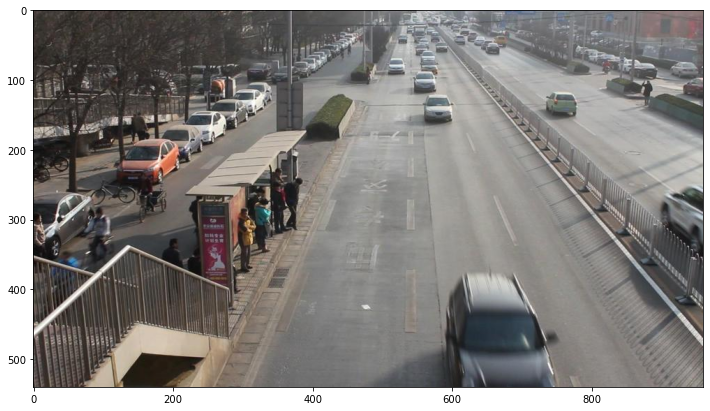

In [56]:
plt.figure(figsize=(12,8))
plt.imshow(img)

In [60]:
bbox = [
    int(det_dict['MVI_20011']['1'][0][1]),
    int(det_dict['MVI_20011']['1'][0][2]),
    int(det_dict['MVI_20011']['1'][0][3]),
    int(det_dict['MVI_20011']['1'][0][4])
]

In [62]:
s = slice_det(img, bbox)

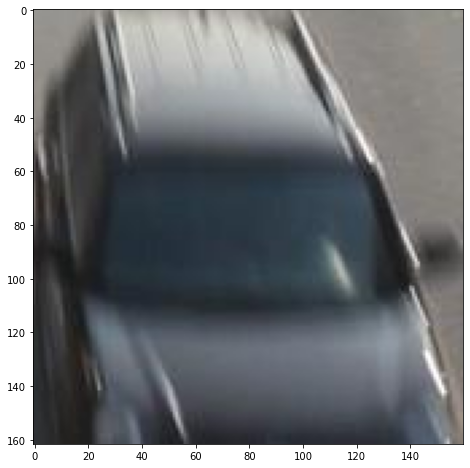

In [63]:
plt.figure(figsize=(10,8))
plt.imshow(s)

In [66]:
s.shape

(162, 160, 3)